In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def normalize(x):
    return np.array(x) / 3000

## Open Data

In [37]:
resolution = 28

input_data_files = ['caroni_negative',
                    'caroni_positive',
                    'additional_negative',
                    'v1_caroni_0.95_thresh',
                    'v1_caroni_0.4-0.5_thresh',
                    'tapajos_v3_0.48-0.5_69',
                    'tapajos_v3_0.4-0.6_121',
                    'tapajos_v4_0.7-0.9_235',
                    'tapajos_2016_cloudy_outliers_190',
                    'tapajos_2016_outliers_187',
                    'corrupted',
                    'amazonas_north_v6-2020_thresh_0.1_0.3-1_170',
                    'amazonas_north_v6-2020_thresh_0.1_0.5-1_154',
                    'amazonas_north_v6-2020_thresh_0.1_0.8-1_125',
                    #'bolivar_2020_v7_thresh_0.5_0.6-0.8_89',
                    'bolivar_amazonas_v7_validated_negatives_220',
                    'bolivar_amazonas_v7_validated_positives_934',
                    'bolivar_amazonas_v7_validated_cloudy_negatives_448'
                   ]

images = np.zeros((0, resolution, resolution, 12))
labels = []
for fname in input_data_files:
    images_fname = str(resolution) + '_px_' + fname + '_images.pkl'
    labels_fname = str(resolution) + '_px_' + fname + '_labels.pkl'
    with open('../data/caroni_train/' + images_fname, 'rb') as f:
        images = np.concatenate((images, pickle.load(f)))
    with open('../data/caroni_train/' + labels_fname, 'rb') as f:
        labels = np.concatenate((labels, pickle.load(f)))

print(len(images), "samples loaded")
print(sum(labels == 1), "positive samples")
print(sum(labels == 0), "negative samples")

6164 samples loaded
1531 positive samples
4633 negative samples


## Prepare Data for Training

In [38]:
#for RGBIR, x = normalize(images[:,:,:,[1,2,3,8]])
x = normalize(images)
y = labels
x, y = shuffle(x, y, random_state=22)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)
print("Num Train:\t\t", len(x_train))
print("Num Test:\t\t", len(x_test))
print(f"Percent Negative Train:\t {100 * sum(y_train == 0.0) / len(y_train):.1f}")
print(f"Percent Negative Test:\t {100 * sum(y_test == 0.0) / len(y_test):.1f}")

num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Num Train:		 5547
Num Test:		 617
Percent Negative Train:	 75.1
Percent Negative Test:	 75.9


## Create Model

In [40]:
input_shape = x_train.shape[1:]
print("Input Shape:", input_shape)

Input Shape: (28, 28, 12)


In [43]:
model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(16, kernel_size=(3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3)),
        layers.Conv2D(32, kernel_size=(3), activation="relu"),
        layers.MaxPooling2D(pool_size=(3)),
        layers.Flatten(),
        layers.Dense(16, activation="relu"),
        #layers.Dropout(0.1),
        layers.Dense(16, activation="relu"),
        layers.Dense(num_classes, activation="softmax")])
model.summary()

model.compile(loss="binary_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 16)        1744      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 6, 6, 32)          4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2, 2, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_24 (Dense)             (None, 16)               

/Users/ckruse/.envs/plastics/lib/python3.6/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5547, 28, 28, 12) (12 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


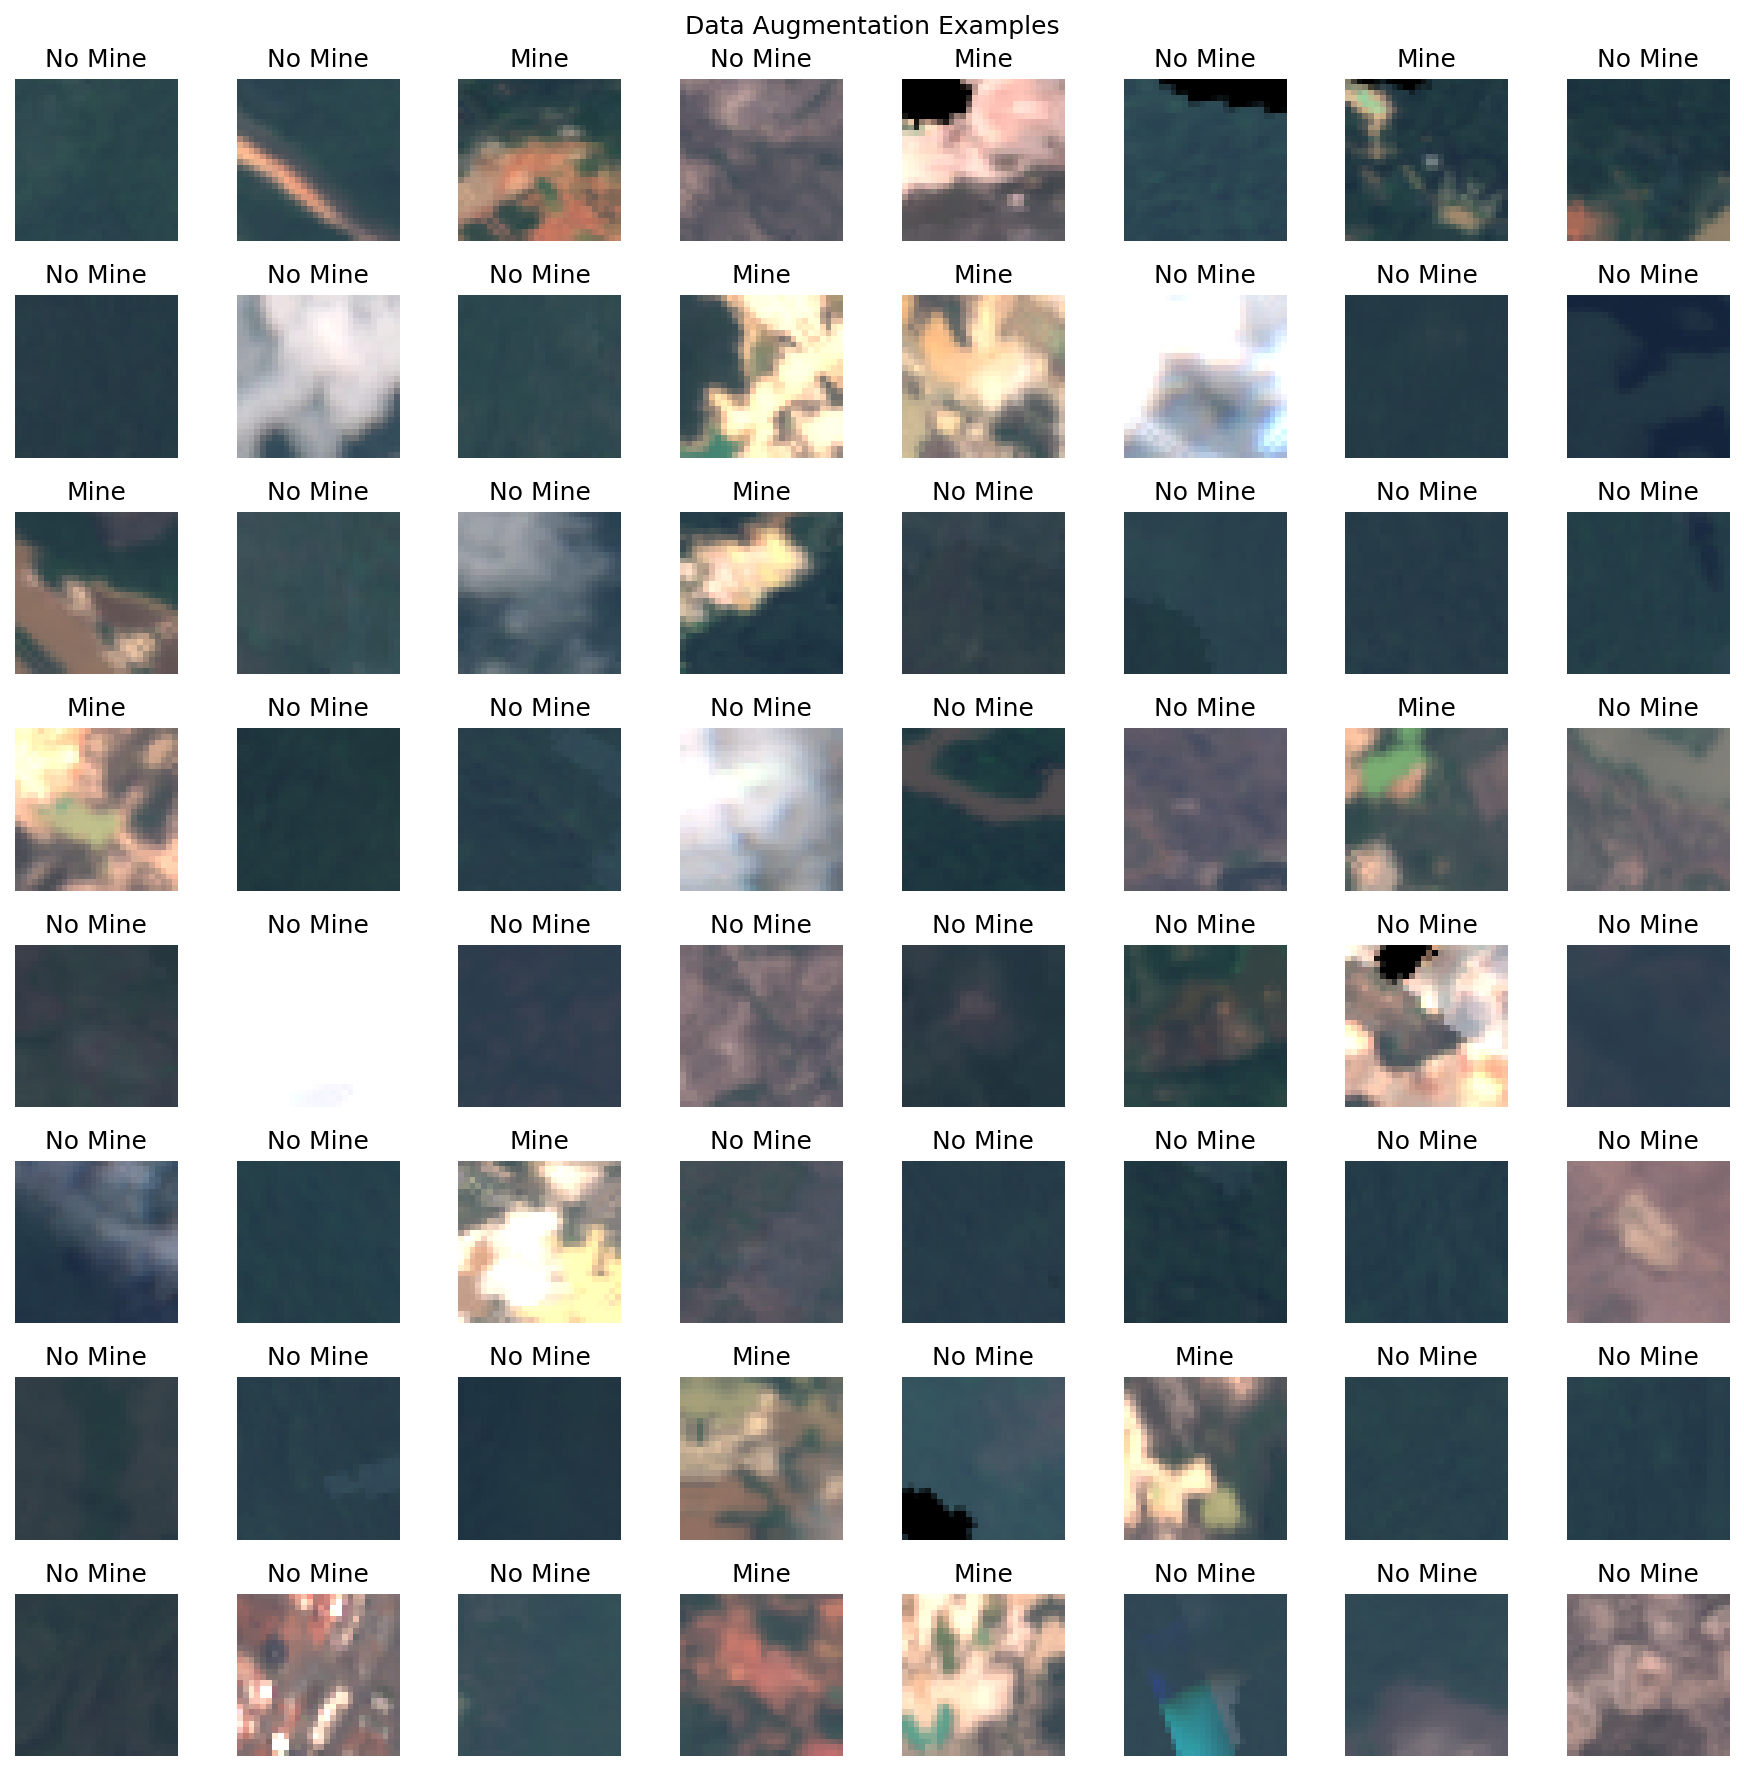

In [44]:
datagen = ImageDataGenerator(
    rotation_range=360,
    #brightness_range=[0.8,1.2],
    width_shift_range=[0.8, 1.2],
    height_shift_range=[0.8, 1.2],
    #shear_range=10,
    zoom_range=[0.8, 1.2],
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='reflect'
)


plt.figure(figsize=(12,12), facecolor=(1,1,1), dpi=150)
images, labels = datagen.flow(x_train, y_train, batch_size=64).next()
for index, (image, label) in enumerate(zip(images, labels)):

    rgb = np.stack((image[:,:,3],
                    image[:,:,2], 
                    image[:,:,1]), axis=-1)
    plt.subplot(8, 8, index+1)
    plt.imshow(np.clip(rgb, 0, 1))
    if label[1] == 1:
        plt.title('Mine')
    else:
        plt.title('No Mine')
    plt.axis('off')
plt.suptitle('Data Augmentation Examples')
plt.tight_layout()
plt.show()
    

## Train Model

In [48]:
batch_size = 16
epochs = 2
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
          epochs=epochs, 
          validation_data = (x_test, y_test),
          verbose = 1
         )

Epoch 1/2
347/347 [==============================] - 9s 25ms/step - loss: 0.1146 - accuracy: 0.9540 - val_loss: 0.0750 - val_accuracy: 0.9724
Epoch 2/2
347/347 [==============================] - 9s 26ms/step - loss: 0.1087 - accuracy: 0.9578 - val_loss: 0.0895 - val_accuracy: 0.9676


In [57]:
model.save(f'../models/{resolution}_px_v9.h5')

## Evaluate Model Performance

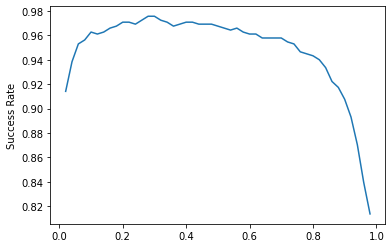

In [53]:
test_model = model

images = x_test
labels = y_test

thresh = []
score = []
for threshold in range(2, 100, 2):
    threshold /= 100
    thresh.append(threshold)
    test_labels = [np.argmax(y) for y in labels]
    test_preds = [pred > threshold for pred in test_model.predict(images)[:,1]]
    score.append(1 - np.sum(np.array(test_labels) != np.array(test_preds)) / len(test_labels))
    #print(np.sum(np.array(test_labels) != np.array(test_preds)), "of", len(test_labels), "test set predictions incorrect")
plt.plot(thresh, score)
plt.ylabel('Success Rate')
plt.show()

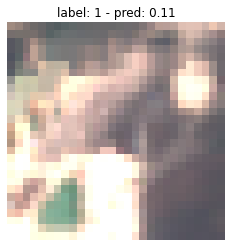

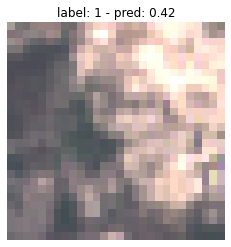

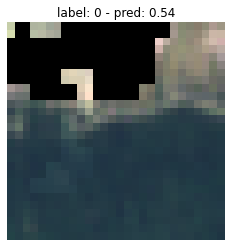

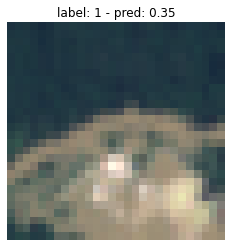

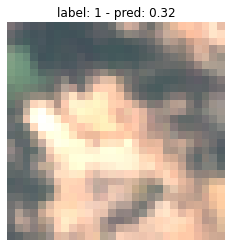

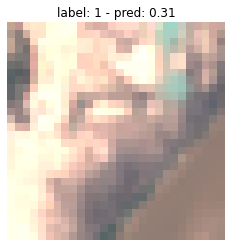

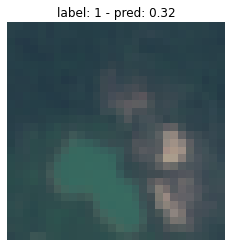

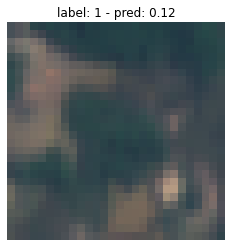

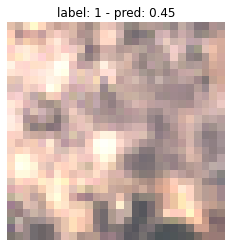

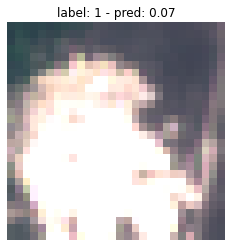

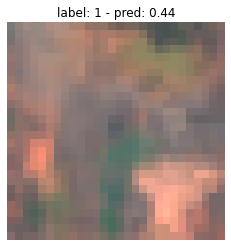

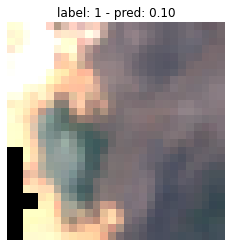

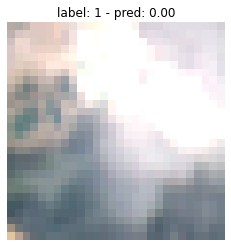

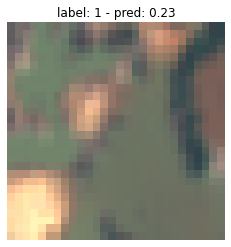

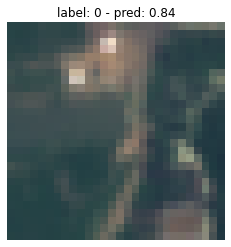

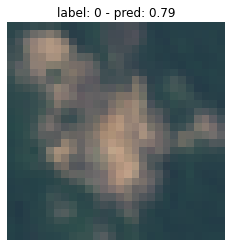

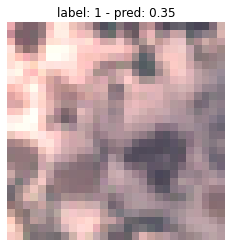

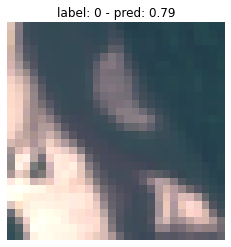

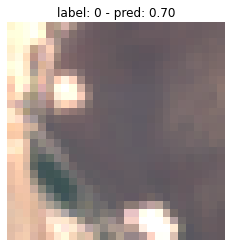

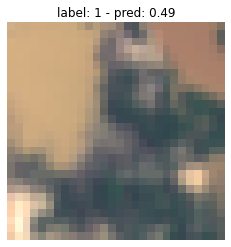

In [56]:
threshold = 0.5

test_labels = [np.argmax(y) for y in labels]
test_preds = [pred > threshold for pred in test_model.predict(images)[:,1]]
for (label, pred, img) in zip(test_labels, test_model.predict(images)[:,1], images):
    if pred < threshold:
        binary_pred = 0
    else:
        binary_pred = 1
    if label != binary_pred:
        rgb = np.stack((img[:,:,3],
                      img[:,:,2],
                      img[:,:,1]), axis=-1)
        plt.imshow(np.clip(rgb, 0, 1))
        plt.title(f"label: {label} - pred: {pred:.2f}")
        plt.axis('off')
        plt.show()

## Test on dataset

In [208]:
resolution = 28

input_data_files = ['corrupted'
                   ]

images = np.zeros((0, resolution, resolution, 12))
labels = []
for fname in input_data_files:
    images_fname = str(resolution) + '_px_' + fname + '_images.pkl'
    labels_fname = str(resolution) + '_px_' + fname + '_labels.pkl'
    with open('../data/caroni_train/' + images_fname, 'rb') as f:
        images = np.concatenate((images, pickle.load(f)))
    with open('../data/caroni_train/' + labels_fname, 'rb') as f:
        labels = np.concatenate((labels, pickle.load(f)))

print(len(images), "samples loaded")
print(sum(labels == 1), "positive samples")
print(sum(labels == 0), "negative samples")

2052 samples loaded
0 positive samples
2052 negative samples


In [209]:
preds = model.predict(normalize(images))[:,1]

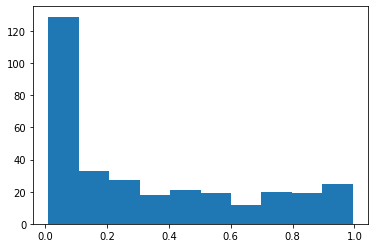

In [210]:
plt.hist(preds[preds > 0.01]);

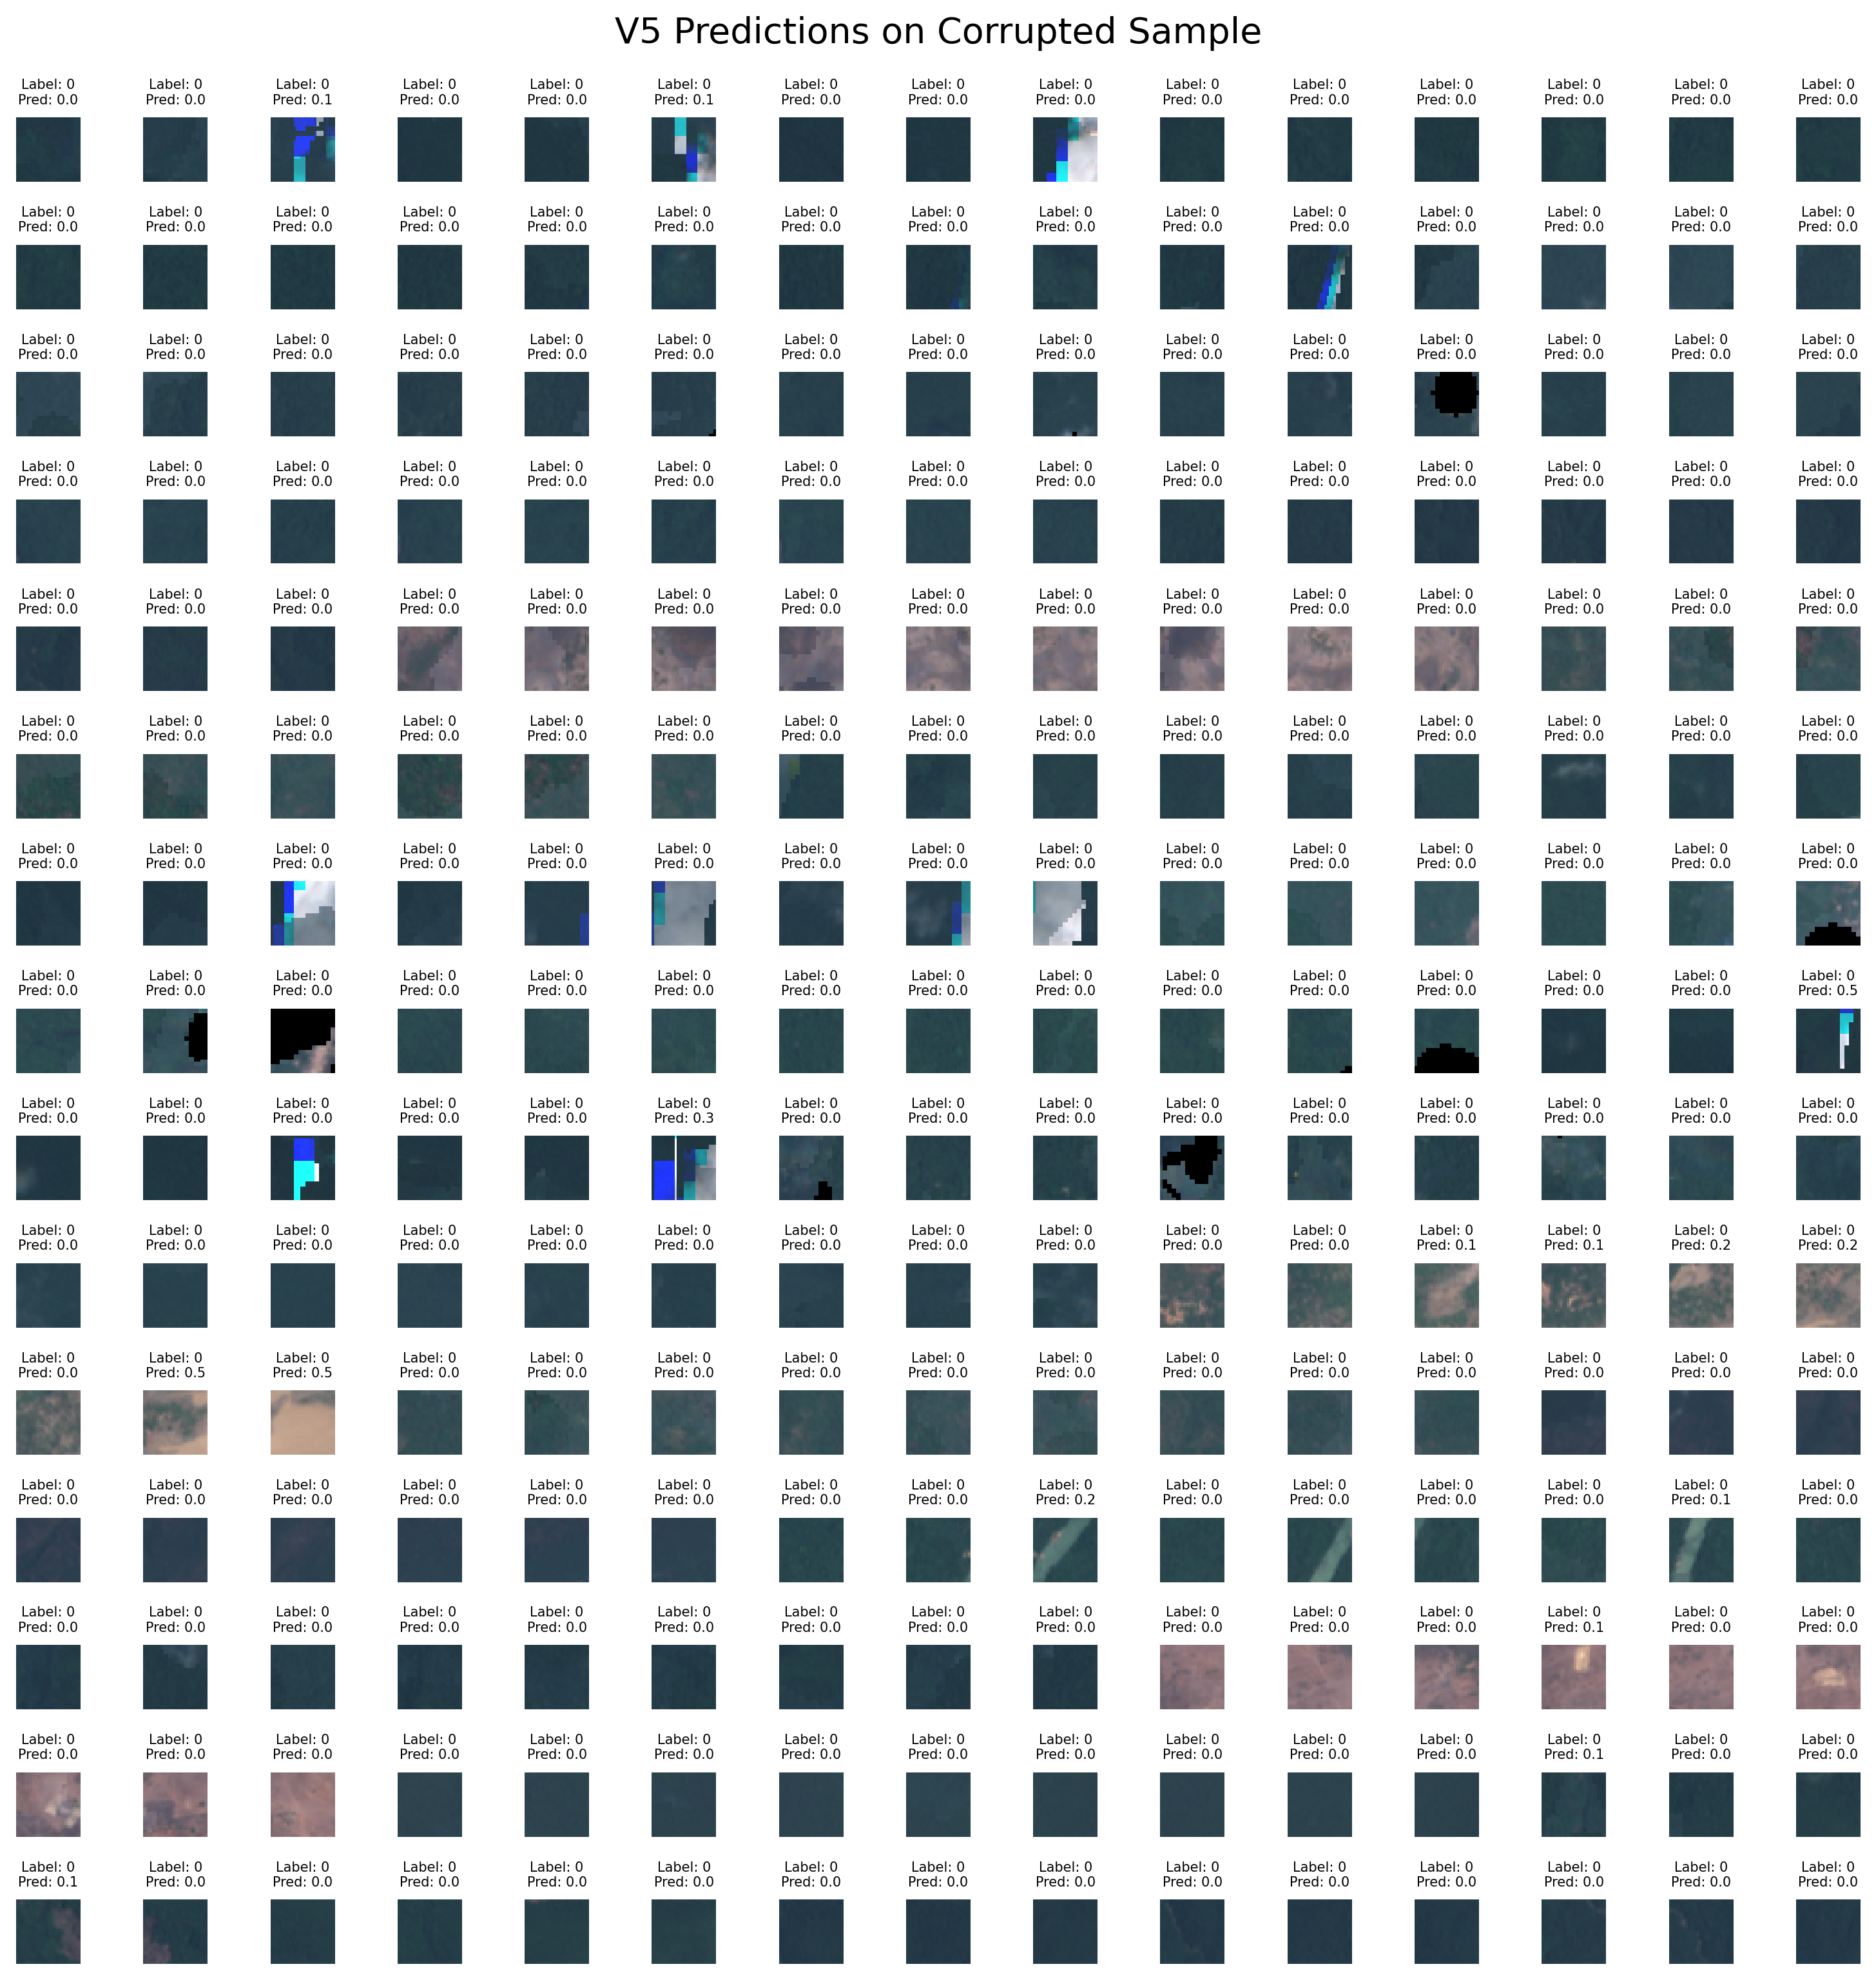

In [213]:
num_img = int(np.ceil(np.sqrt(len(images[:225]))))
plt.figure(figsize=(12,12), dpi=250, facecolor=(1,1,1))
for index, (img, pred, label) in enumerate(zip(images[:225], preds[:225], labels[:225])):
    rgb = np.stack((img[:,:,3],
                    img[:,:,2],
                    img[:,:,1]), axis=-1)
    plt.subplot(num_img, num_img, index + 1)
    plt.imshow(np.clip(normalize(rgb), 0, 1))
    plt.title(f"Label: {label:.0f}\nPred: {pred:.1f}", size=6)
    plt.axis('off')
plt.tight_layout()
name = 'V5 Predictions on Corrupted Sample'
plt.suptitle(name, y=1.02, size=16)
plt.savefig('../figures/' + name + '.png', bbox_inches='tight')
plt.show()